This notebook takes borehole data and SNMR data from the East Kimberley and creates a map of water tables.

Neil Symington
neil.symington@ga.gov.au

In [1]:
%matplotlib inline

In [2]:
from sqlite3 import dbapi2 as sqlite
from shapely.geometry import Polygon, shape
from osgeo import ogr
import json
import pandas as pd
import numpy as np
from hydrogeol_utils import spatial_functions, AEM_utils, plotting_utils, borehole_utils, SNMR_utils
from geophys_utils._netcdf_point_utils import NetCDFPointUtils
from datetime import datetime
import matplotlib.pyplot as plt
import os, sys
import sqlalchemy as db
from sqlalchemy import create_engine, event
import yaml
import rasterio
from rasterio import Affine
from rasterio.warp import reproject, Resampling
import warnings
import math
warnings.filterwarnings("ignore",category =RuntimeWarning)
# Kriging packages
from sklearn.metrics import explained_variance_score
from sklearn.model_selection import cross_val_score

In [3]:
def find_optimal_index(pred_prob):
    # Find the index of the optimal place to put the water table
    
    # If all the probabilities for class one are less than 0.5 then we return a 
    # None and assume the water table is dry for the depth interval of investigation
    
    if np.max(pred_prob[:,1]) < 0.5:
        return None
    
    else:
        # Iterate through the NMR layers and find the average of the 
        # probabilities of being in class 1 (saturated) for all layers
        # below the layer
    
        objective = np.nan*np.ones(shape = pred_prob[:,0].shape, dtype = np.float)
        
        # For the first layer we use the p(saturated of layer 1)
        objective[0] = pred_prob[0,1]

        for i in range(1,pred_prob.shape[0]):
            # For subsequent layers we sum the probability of all layers below being in class
                # one with the probability of all layers above not being in class one
            objective[i] = (np.mean(pred_prob[i:,1]) + 1 - np.mean(pred_prob[:i,1]))/2
            
        return np.argmax(objective)
        

In [4]:
# Get the Water table bounds as a polygon
infile = r"C:\Users\PCUser\Desktop\EK_data\vector\BonaparteWaterTableVector\BonaparteWaterTableBound.shp"
file = ogr.Open(infile)
p = file.GetLayer(0)
#first feature of the shapefile
feature = p.GetFeature(0)
poly = json.loads(feature.ExportToJson())
OrdBon = shape(poly['geometry'])

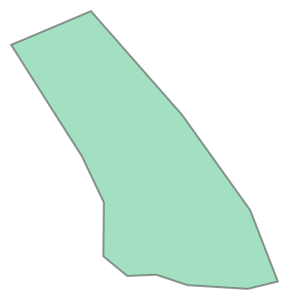

In [5]:
OrdBon

In [6]:
# Open the standing water level data

infile = r"C:\Users\PCUser\Desktop\EK_data\vector\BonaparteWaterTableVector\Bonaparte_SWL.csv"

df_swl = pd.read_csv(infile)

utm_zone = 52
12 points in UTM bounding box: [461179.05, 8321055.219, 478993.383, 8347946.281]


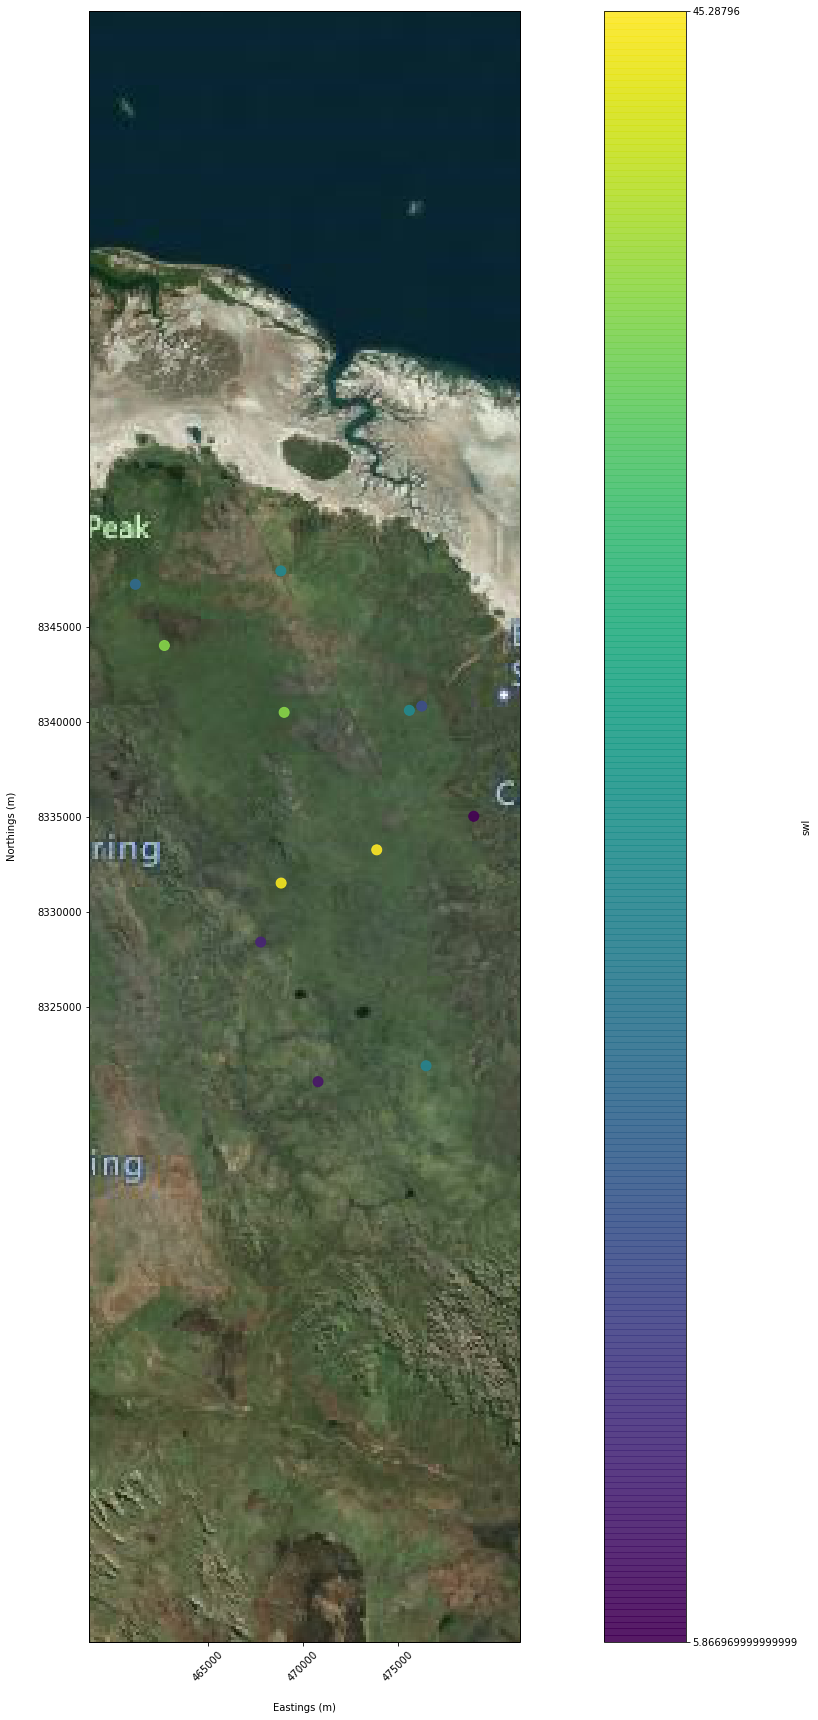

In [7]:
# Plot the bores on a basemap to get an idea of what the swl data looks like

bore_coords = df_swl[['Easting', 'Northing']].values


swl = df_swl["SWL_depth"].values
#wl_mAHD = df_swl["SWL_depth"].values

plotting_utils.plot_point_dataset(bore_coords, "EPSG:28352", swl, 
                   colourbar_label = 'swl', colour_scheme = 'viridis',
                    point_size=100)


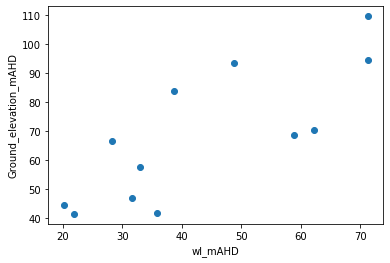

In [8]:
# To demonstrate the relationship between the groundwater elevation and ground elevation we 
# run a scatter plot


plt.scatter(df_swl['wl_mAHD'].values,
           df_swl['Ground_elevation_mAHD'].values)

plt.xlabel('wl_mAHD')
plt.ylabel('Ground_elevation_mAHD')

plt.show()

In [9]:
# Our next tak is to bring the SNMR data in 

# Connect to the SNMR database

DB_PATH = r"C:\Users\PCUser\Desktop\EK_data\SNMR\East_Kimberley_SNMR.sqlite"
        
engine = db.create_engine('sqlite:///' + DB_PATH, module=sqlite)

@event.listens_for(engine, 'connect')
def connect(dbapi_connection, connection_rec):
    dbapi_connection.enable_load_extension(True)
    dbapi_connection.execute('SELECT load_extension("mod_spatialite")')


connection = engine.connect()

query = """

SELECT
              s.site_id,
              s.Field_ID,
              s.mid_X,
              s.mid_Y,
              a.acquisition_id,
              a.pulse_sequence,
              a.pulse_length,
              imm.Depth_of_Investigation
              
FROM 

             sites as s
             JOIN acquisitions as a on s.site_id=a.site_id
             JOIN inverse_model_metadata as imm on a.acquisition_id = imm.acquisition_id

WHERE

            a.pulse_sequence == "FID"

and

            within(s.geom,GeomFromText('{}'));""".format(OrdBon)

df_acquisitions = pd.read_sql_query(query, connection, index_col = 'acquisition_id')

# Since we are interested in the shallow resolution we will use the shorter pulse SNMR


df_acquisitions = df_acquisitions.loc[SNMR_utils.choose_snmr_site_acquisition(df_acquisitions,
                                 pulse_sequence_criteria = ['FID'],
                                 pulse_length_criteria="min")]



In [10]:
# Now extract the SNMR inversions

acquisition_ids = df_acquisitions.index

cols = ['Depth_from', 'Depth_to', 'Mobile_water_content', 'Bound_water_content',
       'Total_water_content', 'T2*', 'acquisition_id', 'inversion_id']

df_inversions= SNMR_utils.extract_snmr_inversions(acquisition_ids, connection,
                                                  mask_below_doi = True)[cols]


# Join the SNMR inversions on acquisition and sites

df_inversions = df_inversions.merge(df_acquisitions, how='inner', left_on='acquisition_id',
                                    right_index=True, )


In [11]:
# For some of our processing below we want to pad the inversions at the top to prvent edge effects

mask = [df_inversions[df_inversions['site_id'] == x]['Depth_from'].argmin() for x in df_inversions['site_id'].unique()]

df_top_layer = df_inversions[df_inversions.index.isin(mask)]

dummy_layer_1 = df_top_layer.copy()

dummy_layer_1['Depth_from'] = -2
dummy_layer_1['Depth_to'] = 0
dummy_layer_1['Mobile_water_content'] = 0.
dummy_layer_1['Bound_water_content'] = 0.
dummy_layer_1['Total_water_content'] = 0.
dummy_layer_1['T2*'] = 0.

dummy_layer_2 = df_top_layer.copy()

dummy_layer_2['Depth_from'] = -4
dummy_layer_2['Depth_to'] = -2
dummy_layer_2['Mobile_water_content'] = 0.
dummy_layer_2['Bound_water_content'] = 0.
dummy_layer_2['Total_water_content'] = 0.
dummy_layer_2['T2*'] = 0.

df_inversions = df_inversions.append(dummy_layer_1)
df_inversions = df_inversions.append(dummy_layer_2)

C:\Users\PCUser\Anaconda3\envs\hydrogeol_utils\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmin' is deprecated, use 'idxmin'
instead.
The behavior of 'argmin' will be corrected to return the positional
minimum in the future. For now, use 'series.values.argmin' or
'np.argmin(np.array(values))' to get the position of the minimum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


In [12]:
# Now we want to discover any colocated sites

SNMR_coords = df_acquisitions[['mid_X', 'mid_Y']].values

distances, indices = spatial_functions.nearest_neighbours(bore_coords,
                                                         SNMR_coords,
                                                         points_required = 1,
                                                         max_distance = 200.)


In [13]:
df_swl['co-located_SNMR_site_id'] = -999

# Iterate through the bores and if a site was returned
# add the site id to the dataframe
for i, (index, row)  in enumerate(df_swl.iterrows()):
    idx = indices[i]
    if idx != len(df_acquisitions):
        # Sincve we only have one acquisition per site we can use site_id
        df_swl.at[index, 'co-located_SNMR_site_id'] = df_acquisitions['site_id'].iloc[idx]

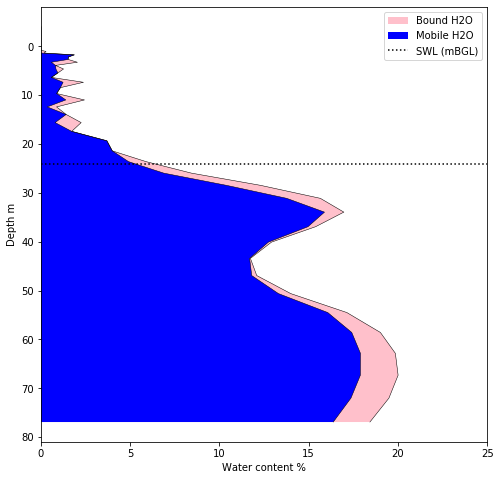

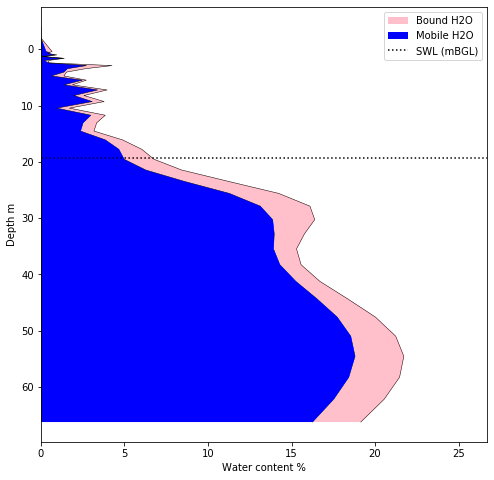

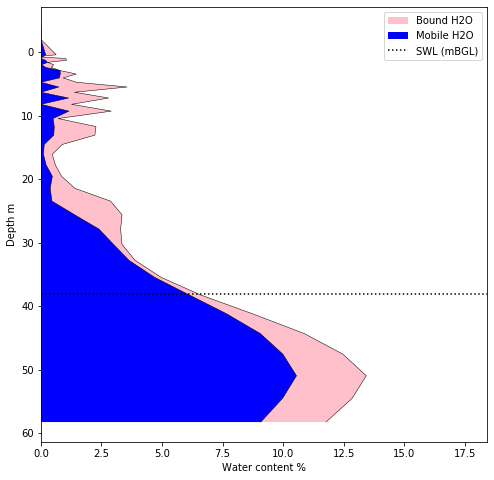

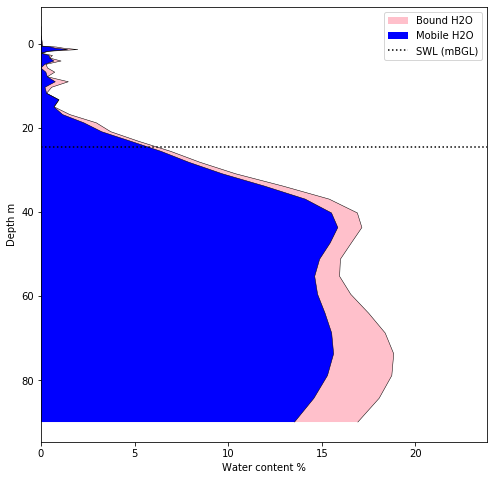

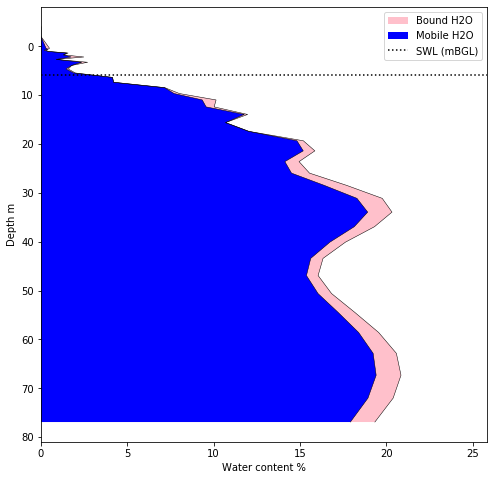

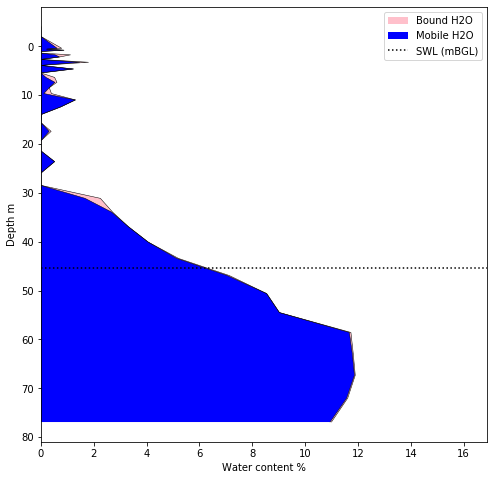

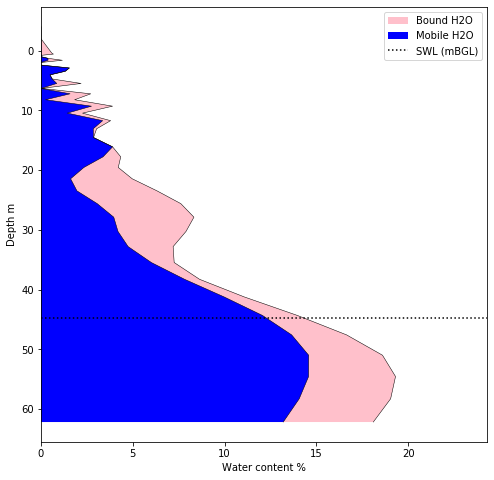

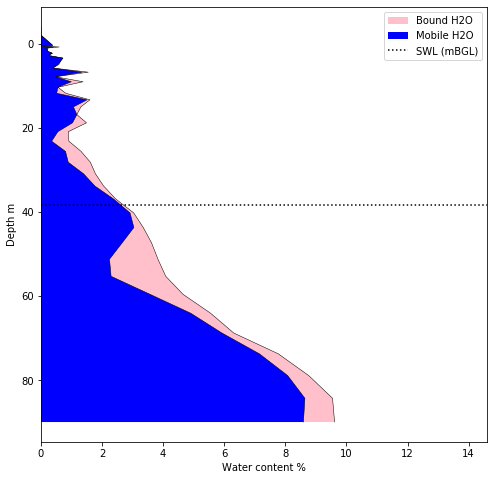

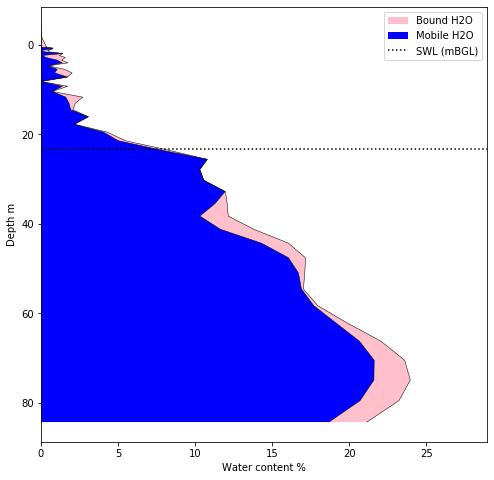

In [14]:
# For each bore with a standing water level plot
# the level on a plot of water level

mask = df_swl['co-located_SNMR_site_id'] != -999

df_swl_subset = df_swl[mask]

# Define outdir

outdir = r"C:\Users\PCUser\Desktop\EK_data\Interp\OrdBonWaterTable\plots"

if not os.path.exists(outdir):
    os.mkdir(outdir)


for index, row in df_swl_subset.iterrows():
    site_id = row['co-located_SNMR_site_id']
    # Extract inversion
    SNMR_inversion = df_inversions[df_inversions['site_id'] == site_id].sort_values(['Depth_from'])

    # Create a plot
    fig, ax = plt.subplots(1,1,figsize = (8,8))
    
    # Add standing water level
    swl_depth = row['SWL_depth']
    
    field_id = df_acquisitions[df_acquisitions['site_id'] == site_id]['Field_ID'].values[0]
    
    doi = SNMR_inversion['Depth_of_Investigation'].unique()[0]
    
    SNMR_utils.plot_profile(ax, SNMR_inversion, doi = None,
                           plot_mobile_water=True)
    # REverse the axis so the gorund is up
    plt.gca().invert_yaxis()
    
    # Plot the water table as a line
    
    ax.hlines(swl_depth, ax.get_xlim()[0], ax.get_xlim()[1],
                  color='k', linestyles='dotted', label = 'SWL (mBGL)')
    
    ax.legend()

    
    fname = row['Borehole_name'] + '_' + field_id + "_comparison_plot.png"
    
    plt.savefig(os.path.join(outdir, fname))
    
    
    

In [15]:


# Calculate key attributes for the optimisation exercise

# Find the mean and standard deviation of a moving window for the mobile water

new_cols = ['Depth_from', 'Depth_to', 'Mobile_water_content', 'Bound_water_content',
       'Total_water_content', 'T2*', 'acquisition_id', 'inversion_id',
       'site_id', 'Field_ID', 'mid_X', 'mid_Y', 'pulse_sequence',
       'pulse_length', 'Depth_of_Investigation',
       'Total_water_content_zero_mean', 'Total_water_content_CV_4',
       'Total_water_content_gradient_4', 'Total_water_content_CV_6',
       'Total_water_content_gradient_6', 'Total_water_content_CV_8',
       'Total_water_content_gradient_8', 'Mobile_water_content_zero_mean',
       'Mobile_water_content_CV_4', 'Mobile_water_content_gradient_4',
       'Mobile_water_content_CV_6', 'Mobile_water_content_gradient_6',
       'Mobile_water_content_CV_8', 'Mobile_water_content_gradient_8',
       'saturated']

df_SNMR_params = pd.DataFrame(columns = new_cols)

window_size = [2,4,6,8]

parameters = ['Total_water_content', 'Mobile_water_content']

for index, row in df_swl_subset.iterrows():
    site_id = row['co-located_SNMR_site_id']
    swl = row['SWL_depth']
    # Extract inversion
    SNMR_inversion = df_inversions[df_inversions['site_id'] == site_id]
    
    # Since we are only intereseted in the top 40 metres or so lets filter the 
    # data frame for the near surface
    SNMR_inversion =  SNMR_inversion[ SNMR_inversion['Depth_to'] < 40.]
    
    # Iterate through the metrixcs
    for param in parameters:
        
        a = SNMR_inversion[param]
    
        # Get mean-zero water content
        SNMR_inversion[param + '_zero_mean'] = a - np.mean(a)
        
        for wind in window_size:
        # Calculate the rolling mean
            rolling_mean = a.rolling(wind,
                                     min_periods = 1).mean()  + 0.001 # Guard agianst dividing by 0
            rolling_std = a.rolling(wind, 
                                    min_periods = 1).std()
            # Coefficient of variation
            SNMR_inversion[param + '_CV' + '_' + str(wind)] = np.divide(rolling_std, rolling_mean)
            
            # Get the gradient
            SNMR_inversion[param + '_gradient' + '_' + str(wind)] = np.gradient(a.rolling(center=False, min_periods = 2,
                                                                                                      window=wind).mean())
            
    
    # Add a label for saturated or no or transition (0.5)
    SNMR_inversion['saturated'] = 0.5
    
    # All values above the water table labeled as unsaturated
    SNMR_inversion.at[SNMR_inversion[SNMR_inversion['Depth_to'] < swl].index, 'saturated'] = 0
    
    SNMR_inversion.at[SNMR_inversion[SNMR_inversion['Depth_from'] > swl].index, 'saturated'] = 1
    
    
    df_SNMR_params = df_SNMR_params.append(SNMR_inversion).dropna()

df_training = df_SNMR_params[df_SNMR_params['saturated'] != 0.5]

C:\Users\PCUser\Anaconda3\envs\hydrogeol_utils\lib\site-packages\pandas\core\frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


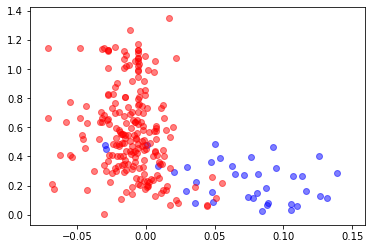

In [16]:
# Scatter plot the zero meaned and coefficient of variation

fig, ax1 = plt.subplots(1,1)

saturated = df_SNMR_params[df_SNMR_params['saturated'] == 1.]
unsaturated = df_SNMR_params[df_SNMR_params['saturated'] == 0.]

ax1.scatter(saturated['Total_water_content_zero_mean'].values, saturated['Total_water_content_CV_4'].values,
           c= 'blue', alpha = 0.5)
ax1.scatter(unsaturated['Total_water_content_zero_mean'].values, unsaturated['Total_water_content_CV_4'].values,
           c= 'red', alpha = 0.5)

plt.show()

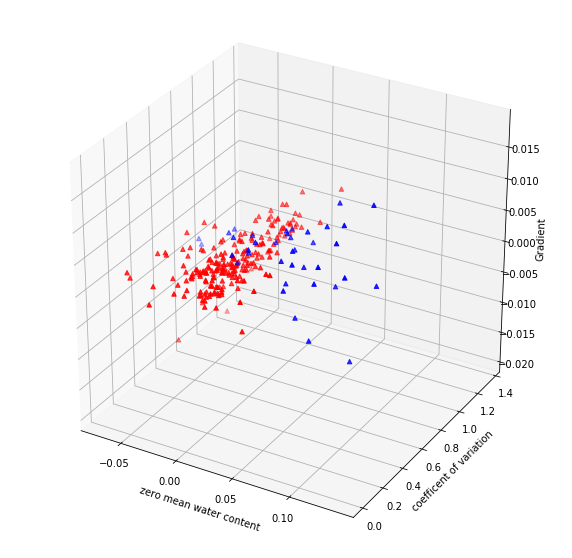

In [17]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(111, projection='3d')

saturated = df_SNMR_params[df_SNMR_params['saturated'] == 1.]
unsaturated = df_SNMR_params[df_SNMR_params['saturated'] == 0.]

ax.scatter(saturated['Total_water_content_zero_mean'].values,
           saturated['Total_water_content_CV_4'].values,
           saturated['Total_water_content_gradient_8'].values, c = 'blue', marker = '^')
           

ax.scatter(unsaturated['Total_water_content_zero_mean'].values,
           unsaturated['Total_water_content_CV_4'].values,
           unsaturated['Total_water_content_gradient_8'].values, c = 'red', marker = '^')

ax.set_xlabel('zero mean water content')
ax.set_ylabel('coefficent of variation')
ax.set_zlabel('Gradient')

plt.show()

In [18]:
# Now we trial a few combinations of parameters, we will 
# judge the results by the cross validation score

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_validate

# Define the three variables


for par in parameters:
    # Window size for the gradient variables
    for gradient_wind in window_size:
        for cv_wind in window_size:
            # Define columns and extract data
            cols = [par + '_zero_mean', par + '_gradient_' + str(gradient_wind),
                   par + '_CV_' + str(cv_wind), par]
            X = df_training[cols].values
            y = df_training['saturated'].astype(int).values
            clf = GradientBoostingClassifier(learning_rate=0.1, max_depth=6,
                                             max_features=0.05, min_samples_leaf=4,
                                             min_samples_split=10, n_estimators=100, subsample=0.25)
            
            # Cross validation
            try:
                cv_results = cross_validate(clf, X, y, cv=5, return_train_score=False)
                print(cols)
                print(np.mean(cv_results['test_score']))
                # Add results to the dicitonary
            except ValueError:
                pass

        


['Total_water_content_zero_mean', 'Total_water_content_gradient_2', 'Total_water_content_CV_2', 'Total_water_content']
0.9567692307692308
['Total_water_content_zero_mean', 'Total_water_content_gradient_2', 'Total_water_content_CV_4', 'Total_water_content']
0.9490769230769232
['Total_water_content_zero_mean', 'Total_water_content_gradient_2', 'Total_water_content_CV_6', 'Total_water_content']
0.9527692307692309
['Total_water_content_zero_mean', 'Total_water_content_gradient_2', 'Total_water_content_CV_8', 'Total_water_content']
0.9567692307692308
['Total_water_content_zero_mean', 'Total_water_content_gradient_4', 'Total_water_content_CV_2', 'Total_water_content']
0.9606153846153846
['Total_water_content_zero_mean', 'Total_water_content_gradient_4', 'Total_water_content_CV_4', 'Total_water_content']
0.9527692307692309
['Total_water_content_zero_mean', 'Total_water_content_gradient_4', 'Total_water_content_CV_6', 'Total_water_content']
0.9566153846153845
['Total_water_content_zero_mean', 

In [19]:
# Train a classifier on this to get probability of saturation given
# the zero mean, coefficient of variation and gradient

# WE ignore the transition zone so it is a binary classification

from sklearn.model_selection import train_test_split

train_cols = ['Total_water_content_zero_mean',
             'Total_water_content_gradient_4',
             'Total_water_content_CV_4',
             'Total_water_content']



X = df_training[train_cols].values
y = df_training['saturated'].astype(int).values

# Split
X_train, X_test, y_train, y_test = train_test_split(X,y, train_size=0.75,
                                                    test_size=0.25, shuffle=True)



In [20]:
cv_results

{'fit_time': array([0.06682181, 0.06487679, 0.06283212, 0.07380223, 0.06881547]),
 'score_time': array([0.0009985 , 0.00099707, 0.0009973 , 0.00099707, 0.0009973 ]),
 'test_score': array([0.98076923, 1.        , 0.96153846, 0.96      , 1.        ])}

In [21]:
cv_wind = 4
grad_wind = 4

cols = ['Total_water_content_zero_mean', 'Total_water_content_gradient_' + str(grad_wind),
        'Total_water_content_CV_' + str(cv_wind),
       'Total_water_content']

X = df_training[cols].values

y = df_training['saturated'].astype(int).values

clf = GradientBoostingClassifier(learning_rate=0.1, max_depth=6,
                                 max_features=0.05, min_samples_leaf=4,
                                 min_samples_split=10, n_estimators=100, subsample=0.25)

clf.fit(X,y)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=6,
                           max_features=0.05, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=4, min_samples_split=10,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='auto',
                           random_state=None, subsample=0.25, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [22]:
cols

['Total_water_content_zero_mean',
 'Total_water_content_gradient_4',
 'Total_water_content_CV_4',
 'Total_water_content']

In [23]:
# Now lets use this to predict the rest of our SNMR soundings

# Cut out only the top 80 metres

df_inversions = df_inversions[df_inversions['Depth_to'] < 80.]


# Find the mean and standard deviation of a moving window for the mobile water

for site in df_inversions.site_id.unique():

    # Extract inversion
    SNMR_inversion = df_inversions[df_inversions['site_id'] == site].sort_values(['Depth_from'])
    
    # Iterate through the metrixcs
    a = SNMR_inversion['Total_water_content']
    
    # Get mean-zero water content
    SNMR_inversion['Total_water_content_zero_mean'] = a - np.mean(a)
    
    # Get the optimal gradient
    # Calculate the rolling mean
    rolling_mean = a.rolling(cv_wind, min_periods = 1).mean() + 0.001 # Guard agianst dividing by 0
    rolling_std = a.rolling(cv_wind, min_periods = 1).std()
    
    # Calculate coefficient of variation
    SNMR_inversion['Total_water_content_CV'] = np.divide(rolling_std, rolling_mean)
            
    # Get the gradient
    SNMR_inversion['Total_water_content_gradient'] = np.gradient(a.rolling(center=False, min_periods = 2,
                                                                           window=grad_wind).mean())
    SNMR_inversion = SNMR_inversion.dropna()
    
    # Now predict the saturation of the profile
    X = SNMR_inversion[['Total_water_content_zero_mean',
                        'Total_water_content_gradient',
                        'Total_water_content_CV',
                        'Total_water_content']]
    
    pred = clf.predict(X)
    
    pred_prob =clf.predict_proba(X)
    # Get the optimal change point
    
    idx = find_optimal_index(pred_prob)
    
    # Estimate the water table at each site
    if idx is not None:
        water_table = SNMR_inversion['Depth_from'].iloc[idx]
    
        # Add to the acquisitions dataframe
        ind = df_acquisitions[df_acquisitions['site_id'] == site].index
    
        df_acquisitions.at[ind, 'modelled_water_table'] = water_table
    else:
        print(site)

    

12
16
25
44
49
70
139
140
141
142


In [25]:
df_inversions[df_inversions['site_id'] == 12]

,Depth_from,Depth_to,Mobile_water_content,Bound_water_content,Total_water_content,T2*,acquisition_id,inversion_id,site_id,Field_ID,mid_X,mid_Y,pulse_sequence,pulse_length,Depth_of_Investigation
table_id,,,,,,,,,,,,,,,
950,0.417808,0.592321,0.000530,0.000411,0.000942,0.035076,20,19,12,104201_trans_st2,471560.0103,8339284.634,FID,40.0,74.430066
951,0.592321,0.809702,0.000492,0.000000,0.000492,0.182429,20,19,12,104201_trans_st2,471560.0103,8339284.634,FID,40.0,74.430066
952,0.809702,1.074661,0.001799,0.000000,0.001799,0.336276,20,19,12,104201_trans_st2,471560.0103,8339284.634,FID,40.0,74.430066
953,1.074661,1.391905,0.001626,0.000692,0.002319,0.137303,20,19,12,104201_trans_st2,471560.0103,8339284.634,FID,40.0,74.430066
954,1.391905,1.766143,0.001860,0.001856,0.003716,0.031622,20,19,12,104201_trans_st2,471560.0103,8339284.634,FID,40.0,74.430066
955,1.766143,2.202083,0.001248,0.000000,0.001248,0.358766,20,19,12,104201_trans_st2,471560.0103,8339284.634,FID,40.0,74.430066
956,2.202083,2.704433,0.002635,0.000000,0.002635,0.224701,20,19,12,104201_trans_st2,471560.0103,8339284.634,FID,40.0,74.430066
957,2.704433,3.277902,0.002898,0.000000,0.002898,0.334547,20,19,12,104201_trans_st2,471560.0103,8339284.634,FID,40.0,74.430066
958,3.277902,3.927197,0.001410,0.000000,0.001410,0.269104,20,19,12,104201_trans_st2,471560.0103,8339284.634,FID,40.0,74.430066


In [26]:
# Now we plot these over the profiles

# Define outdir

outdir = r"C:\Users\PCUser\Desktop\EK_data\Interp\OrdBonWaterTable\water_table_plots_run1"

if not os.path.exists(outdir):
    os.mkdir(outdir)


for index, row in df_acquisitions.iterrows():
    
    site_id = row['site_id']
    # Extract inversion
    SNMR_inversion = df_inversions[df_inversions['site_id'] == site_id].sort_values(['Depth_from'])
    # Create a plot
    fig, ax = plt.subplots(1,1,figsize = (8,8))
    
    # Add standing water level
    water_table = row['modelled_water_table']
    
    field_id = row['Field_ID']
    
    SNMR_utils.plot_profile(ax, SNMR_inversion, doi = None,
                           plot_mobile_water=True)
    
    # REverse the axis so the gorund is up
    plt.gca().invert_yaxis()
    
    # Plot the water table as a line
    
    ax.hlines(water_table, ax.get_xlim()[0], ax.get_xlim()[1],
                  color='green', linestyles='dotted', label = 'modelled water table')
    
    # Add SWL if available
    if site_id in df_swl['co-located_SNMR_site_id'].values:
        
        swl = df_swl[df_swl['co-located_SNMR_site_id'] == site_id]['SWL_depth'].values[0]
        
        ax.hlines(swl, ax.get_xlim()[0], ax.get_xlim()[1],
                  color='blue', linestyles='dashed', label = 'SWL')
        
        
        
    ax.legend()

    
    fname = field_id + "_modelled_water_table_plot.png"
    
    plt.savefig(os.path.join(outdir, fname))
    
    plt.close()

In [27]:
df_compare = df_swl.merge(df_acquisitions, left_on = 'co-located_SNMR_site_id',
            right_on = 'site_id')

df_compare['RMSE'] = np.sqrt(np.square(df_compare['SWL_depth'].values - df_compare['modelled_water_table'].values))

print(df_compare['RMSE'].mean())

outfile = r"C:\Users\PCUser\Desktop\EK_data\Interp\OrdBonWaterTable\results\swl_snmr_modelling_comparison_run1.csv"

df_compare.to_csv(outfile)

0.973211125000002


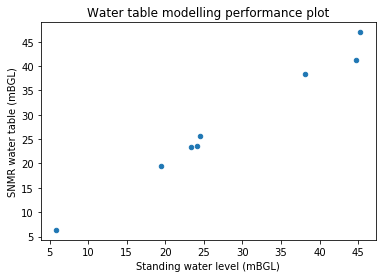

In [29]:
#report plot

%matplotlib inline

import pandas as pd
import matplotlib.pyplot as plt

df_compare = pd.read_csv(outfile)

ax = df_compare.plot.scatter(x = 'SWL_depth', y = 'modelled_water_table')

ax.set_xlabel('Standing water level (mBGL)')
ax.set_ylabel('SNMR water table (mBGL)')
ax.set_title('Water table modelling performance plot')

plt.savefig(r"C:\Users\PCUser\Desktop\EK_data\Interp\OrdBonWaterTable\results\water_table_modelling_fig.png",
           dpi = 300)

In [30]:
# Now we will create an xy water table depth dataset to interpolate

# Drop nas from the df_acquisitions

df_snmr_watertable = df_acquisitions.dropna(subset = ['modelled_water_table'])[['Field_ID','site_id','mid_X', 'mid_Y',
                                                                                'modelled_water_table']]

# Now drop columns that have swl assosicates

df_snmr_watertable[~df_snmr_watertable['site_id'].isin(df_swl['co-located_SNMR_site_id'].values)]

# Now get the x,y,depth as arrays

snmr_wt = df_snmr_watertable[['Field_ID','mid_X', 'mid_Y','modelled_water_table']].rename(columns = {'Field_ID':'id',
                                                                                                    'mid_X': 'Easting',
                                                                                        'mid_Y': 'Northing',
                                                                                         'modelled_water_table':
                                                                                         'water_table_depth'})


snmr_wt['source'] = 'SNMR_modelled'

In [31]:
snmr_wt

,id,Easting,Northing,water_table_depth,source
acquisition_id,,,,,
3,2pm,468863.3010,8347878.272,23.615782,SNMR_modelled
7,6m,458571.4590,8345568.043,43.416740,SNMR_modelled
9,strat_trans_st3,458155.4900,8345306.897,31.129037,SNMR_modelled
10,strat_trans_st2,457781.0190,8345010.551,25.967472,SNMR_modelled
12,4m,476976.7710,8318919.739,40.087472,SNMR_modelled
13,centr_spat_st_2,475577.6060,8325315.362,40.087472,SNMR_modelled
16,dafwa_bore,473744.1170,8333212.662,46.925417,SNMR_modelled
18,1pm,478942.9080,8335025.666,6.377128,SNMR_modelled
22,104201_trans_st4,471146.8500,8339140.750,58.574982,SNMR_modelled


In [32]:
df_swl_ = df_swl[['Borehole_name','Easting', 'Northing', 'SWL_depth']]
df_swl_.rename(columns = {'Borehole_name':'id',
                          'SWL_depth': 'water_table_depth'}, inplace = True)


df_swl_['source'] = 'borehole_measurement'

C:\Users\PCUser\Anaconda3\envs\hydrogeol_utils\lib\site-packages\pandas\core\frame.py:4238: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(**kwargs)
C:\Users\PCUser\Anaconda3\envs\hydrogeol_utils\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [53]:
df_swl

,Borehole_name,Easting,Northing,Ground_elevation_mAHD,wl_mAHD,SWL_depth,co-located_SNMR_site_id
0,17BP02I,468839.000,8347946.281,44.29117,20.13,24.16117,2
1,17BP05I,461179.050,8347241.926,41.34657,21.95,19.39657,48
2,17BP04I,462705.715,8344019.122,66.37539,28.31,38.06539,52
3,BONAPARTE_1_WATER_BORE_2,476256.044,8340826.592,46.94127,31.70,15.24127,-999
4,BONAPARTE_1_WATER_BORE_1,475605.004,8340605.520,57.39019,32.93,24.46019,172
5,17BP01I,478993.383,8335027.204,41.70697,35.84,5.86697,11
6,13BP01I,473886.620,8333260.730,83.90796,38.62,45.28796,10
7,17BP07I,468853.882,8331510.047,93.45619,48.78,44.67619,45
8,BONAPARTE_2_WATER_BORE,467779.058,8328404.941,68.62453,58.82,9.80453,-999
9,17BP03I,469012.153,8340498.650,109.50410,71.23,38.27410,70


In [45]:
# Create an array with x, y, water table and an estimate of uncertainty
df_water_tables = df_swl_.append(snmr_wt)


outdir = r"C:\Users\PCUser\Desktop\EK_data\Interp\OrdBonWaterTable\results"

if not os.path.exists(outdir):
    os.mkdir(outdir)

for index, row in df_water_tables.iterrows():
    if row['source'] == "SNMR_modelled":
        df_water_tables.at[index, 'link'] = os.path.join(outdir, row['id'] + "_modelled_water_table_plot.png")

df_water_tables.to_csv(os.path.join(outdir, "OrdBon_water_table_run1.csv"))

In [60]:
# There are some dodgy data, remove for now

bad_sites = ['OB18_19',#water table at the surface
             'OB18_23', "OB18_25"] # Bad pick

df_water_tables_subset = df_water_tables[~df_water_tables['id'].isin(bad_sites)]

utm_zone = 52
69 points in UTM bounding box: [457781.019, 8315035.976, 487663.904, 8349684.115]


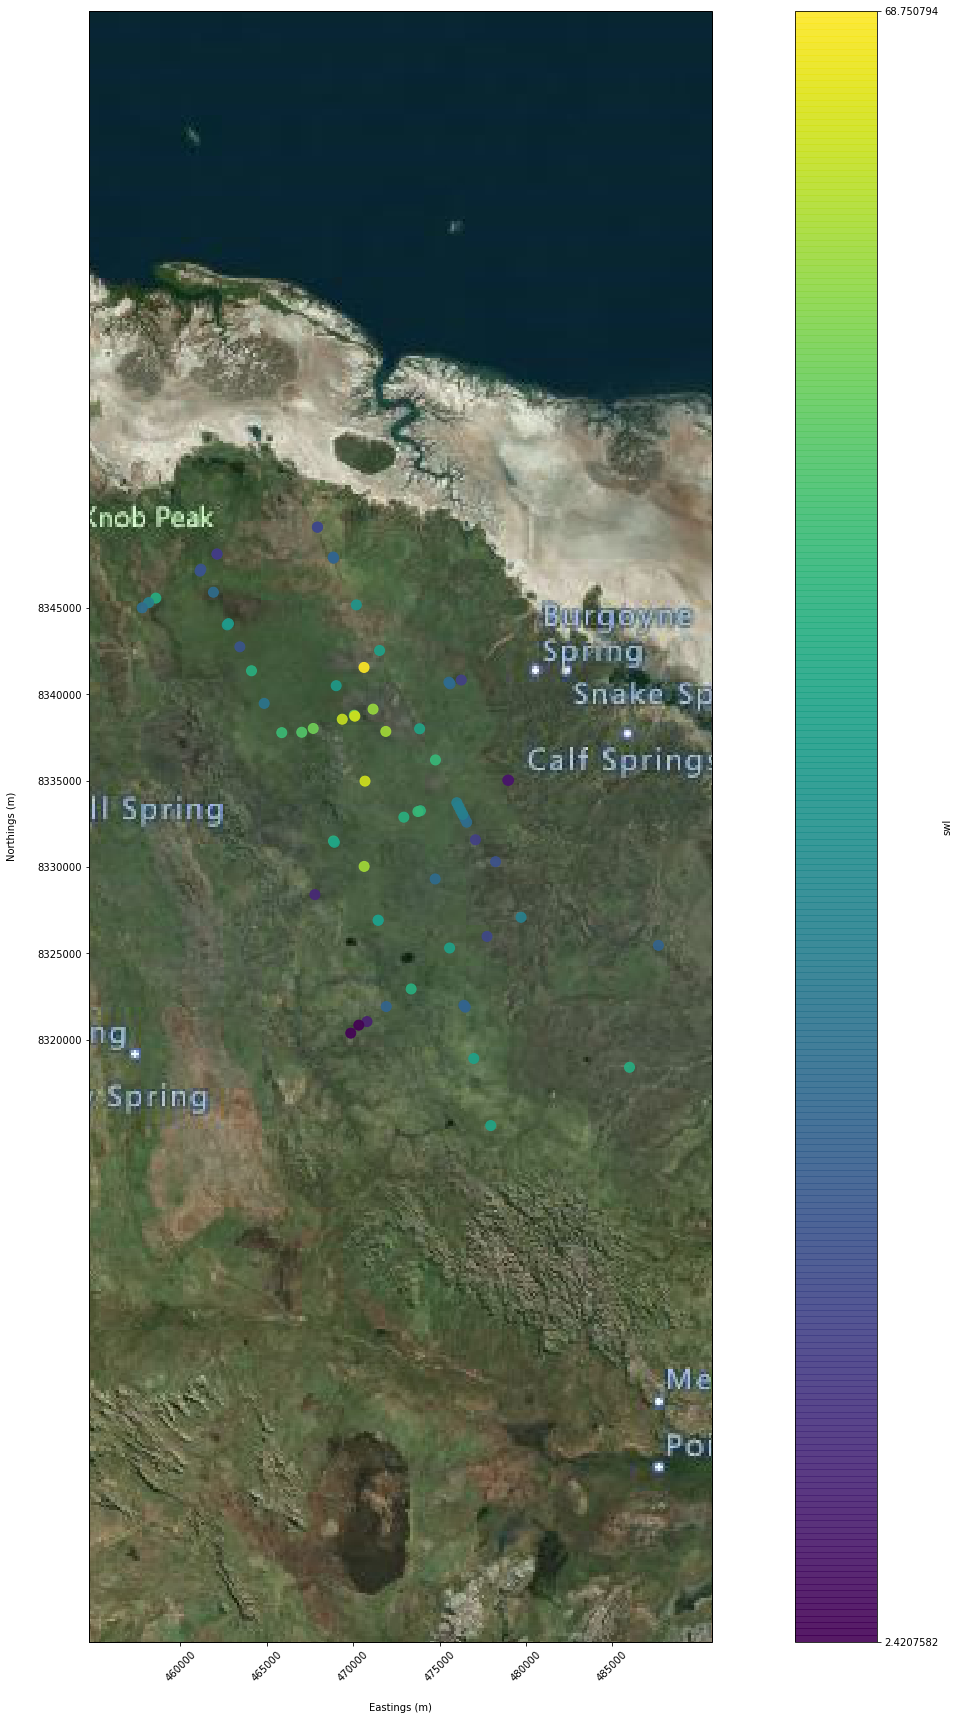

In [61]:
# Plot the bores on a basemap to get an idea of what the swl data looks like

coords = df_water_tables_subset[['Easting', 'Northing']].values


wt = df_water_tables_subset["water_table_depth"].values
#wl_mAHD = df_swl["SWL_depth"].values

plotting_utils.plot_point_dataset(coords, "EPSG:28352", wt, 
                   colourbar_label = 'swl', colour_scheme = 'viridis',
                    point_size=100)


In [62]:
# Create a new grid using the extents of the borehole data we are modelling
X = df_water_tables_subset['Easting']
Y = df_water_tables_subset['Northing']

# Define grid
gridx = np.arange((math.floor(X.min() / 10.0)) * 10 - 1000.,
                  (math.ceil(X.max() / 10.0)) * 10 + 1000., 100)

gridy = np.arange((math.floor(Y.min() / 10.0)) * 10 - 1000.,
                  (math.ceil(Y.max() / 10.0)) * 10 + 1000., 100)[::-1]

# WE are going to interpolate elevation data onto this grid using the lidar
tif_file = r"C:\Users\PCUser\Desktop\EK_data\LiDAR\EK_lidar_cubic_5x5.tif"

# Define the temporary output for the grid

elev_outfile = r"C:\temp\lidar_elev_1000m.tif"

# Create the new file
spatial_functions.resample_raster(tif_file, elev_outfile, gridx, gridy, driver='GTiff',
                 null = -9999)



In [63]:
row

id                                                                  OB18_02
Easting                                                              462113
Northing                                                        8.34812e+06
water_table_depth                                                   13.3687
source                                                        SNMR_modelled
link                      C:\Users\PCUser\Desktop\EK_data\Interp\OrdBonW...
lid100m_elevation_mAHD                                              32.9444
elev_mAHD                                                               NaN
Name: 327, dtype: object

In [64]:
# Open the new file
elev_src = rasterio.open(elev_outfile)

# Iterator yielding the nearest neighbour
vals = elev_src.sample(coords)

# Add the 50 m grid elevation to the dataframe
df_water_tables_subset['elev_mAHD'] = np.nan

for index, row in df_water_tables_subset.iterrows():
    if row['source'] == 'SNMR_modelled':

        df_water_tables_subset.at[index, 'elev_mAHD'] = next(vals)[0]
    else:
        df_water_tables_subset.at[index, 'elev_mAHD'] = df_swl[df_swl['Borehole_name'] == row['id']]['Ground_elevation_mAHD']
        _ = next(vals)
        


C:\Users\PCUser\Anaconda3\envs\hydrogeol_utils\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [65]:
df_water_tables_subset

,id,Easting,Northing,water_table_depth,source,link,elev_mAHD
0,17BP02I,468839.0000,8347946.281,24.161170,borehole_measurement,NaN,44.291170
1,17BP05I,461179.0500,8347241.926,19.396570,borehole_measurement,NaN,41.346570
2,17BP04I,462705.7150,8344019.122,38.065390,borehole_measurement,NaN,66.375390
3,BONAPARTE_1_WATER_BORE_2,476256.0440,8340826.592,15.241270,borehole_measurement,C:\Users\PCUser\Desktop\EK_data\Interp\OrdBonW...,44.689334
4,BONAPARTE_1_WATER_BORE_1,475605.0040,8340605.520,24.460190,borehole_measurement,NaN,57.390190
...,...,...,...,...,...,...,...
288,OB18_01,462113.2682,8348119.891,20.940273,SNMR_modelled,C:\Users\PCUser\Desktop\EK_data\Interp\OrdBonW...,32.944389
315,OB18_04,475536.7870,8340701.327,25.614455,SNMR_modelled,C:\Users\PCUser\Desktop\EK_data\Interp\OrdBonW...,57.392615
318,OB18_22,479714.1973,8327091.910,30.937070,SNMR_modelled,C:\Users\PCUser\Desktop\EK_data\Interp\OrdBonW...,39.161883
323,OB18_07,469855.8995,8320385.280,2.839100,SNMR_modelled,C:\Users\PCUser\Desktop\EK_data\Interp\OrdBonW...,59.664809


In [67]:
df_water_tables_subset['water_table_elevation'] = df_water_tables_subset['elev_mAHD'] - df_water_tables_subset['water_table_depth']

C:\Users\PCUser\Anaconda3\envs\hydrogeol_utils\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


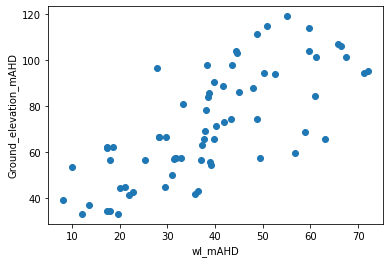

In [68]:
# To demonstrate the relationship between the groundwater elevation and ground elevation we 
# run a scatter plot


plt.scatter(df_water_tables_subset['water_table_elevation'].values,
           df_water_tables_subset['elev_mAHD'].values)

plt.xlabel('wl_mAHD')
plt.ylabel('Ground_elevation_mAHD')

plt.show()

In [72]:
df_water_tables_subset.to_csv(os.path.join(outdir, "OrdBon_water_table_run1_culled.csv"))

utm_zone = 52
69 points in UTM bounding box: [457781.019, 8315035.976, 487663.904, 8349684.115]


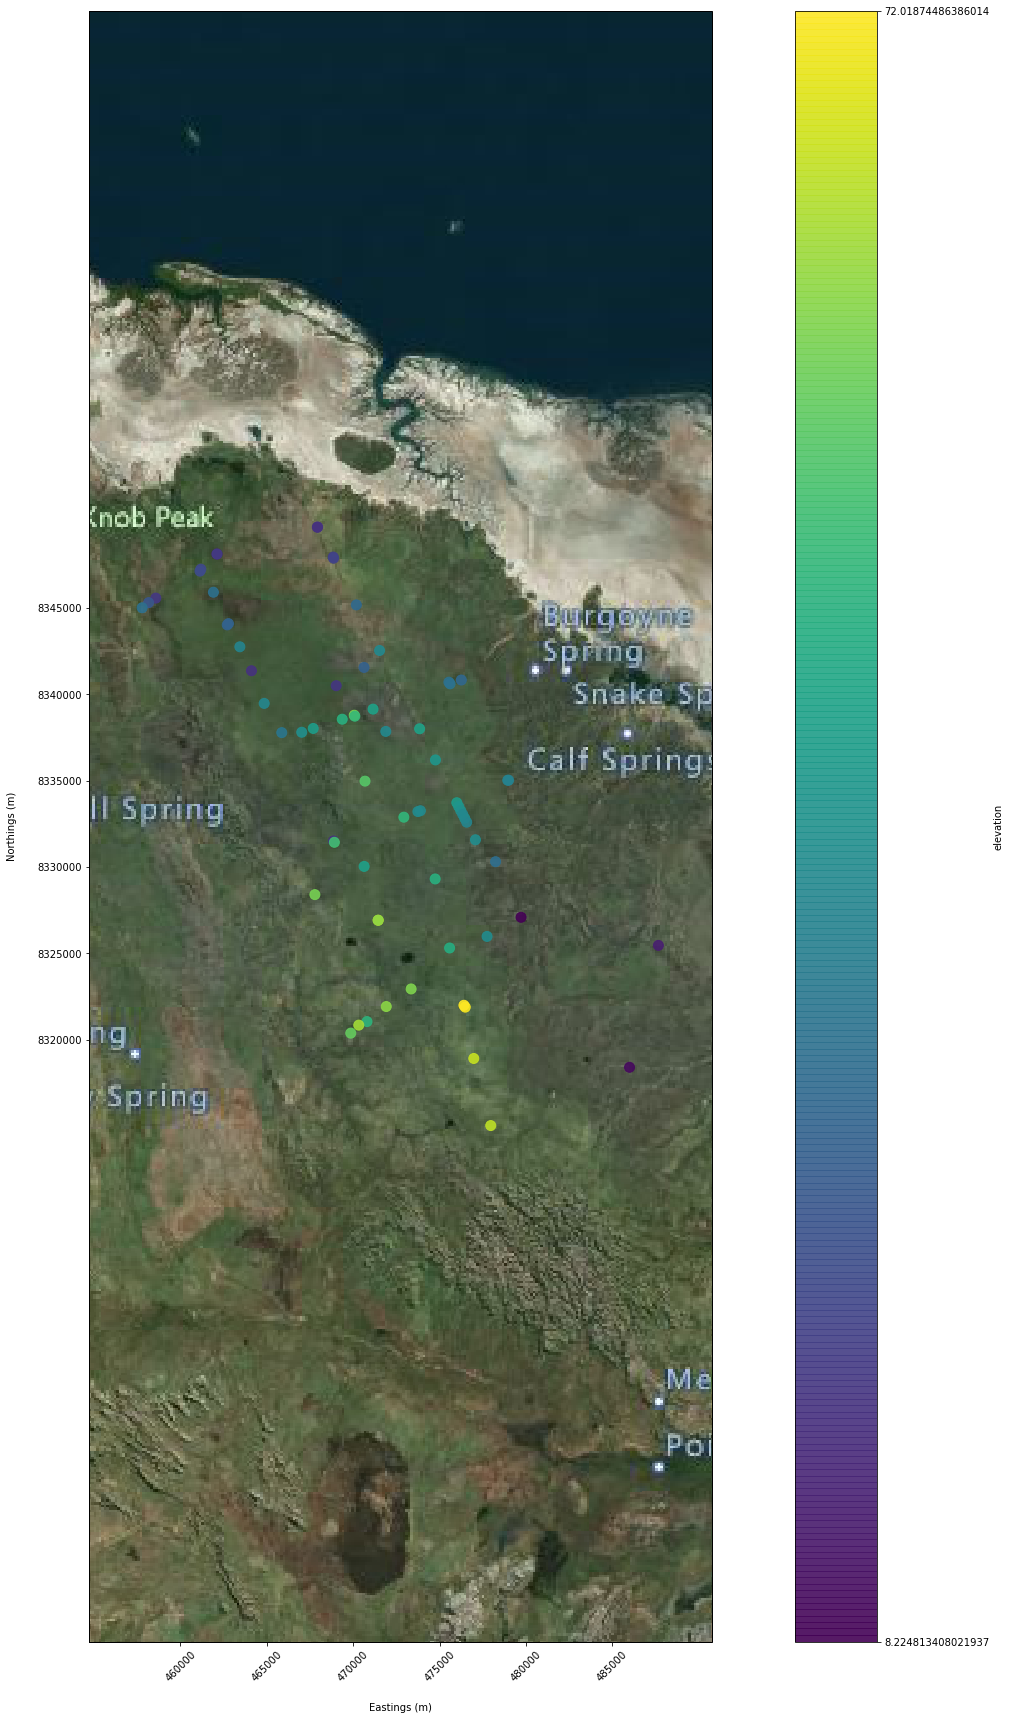

In [71]:
# Plot the bores on a basemap to get an idea of what the swl data looks like

coords = df_water_tables_subset[['Easting', 'Northing']].values


wte = df_water_tables_subset["water_table_elevation"].values

plotting_utils.plot_point_dataset(coords, "EPSG:28352", wte, 
                   colourbar_label = 'elevation', colour_scheme = 'viridis',
                    point_size=100)